## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below






In [88]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score


\**QUESTION:** Load dataset and display some lines of the csv file.

In [89]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Colab_IA_EMBARQUEE/ai4i2020.csv")

# Afficher les premières lignes
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

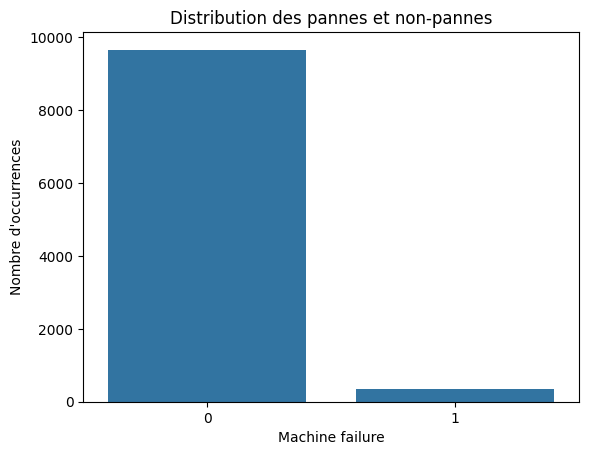

In [90]:
failure_counts = df['Machine failure'].value_counts()

# Afficher le graphique en barres
sns.barplot(x=failure_counts.index, y=failure_counts.values)
plt.title('Distribution des pannes et non-pannes')
plt.xlabel('Machine failure')
plt.ylabel('Nombre d\'occurrences')
plt.show()

**ANALYSIS QUESTION:** What do you observe?

La grande majorité des machines ne sont pas cassés

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

"Write here your response"

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

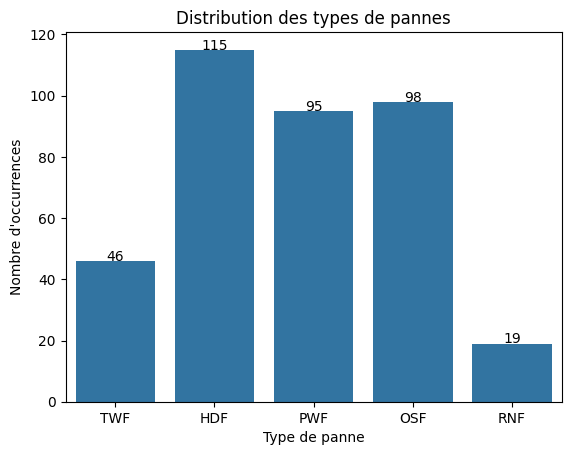

In [91]:
failure_types = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum()

# Afficher le graphique en barres
sns.barplot(x=failure_types.index, y=failure_types.values)
plt.title('Distribution des types de pannes')
plt.xlabel('Type de panne')
plt.ylabel('Nombre d\'occurrences')
for i, v in enumerate(failure_types.values):
    plt.text(i, v + 0.1, str(v), ha='center')
plt.show()

**ANALYSIS QUESTION:** What do you observe?

On observe de la répartition des différents échecs possibles. La failure la plus courante est donc lié à la dissipation de chaleur

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

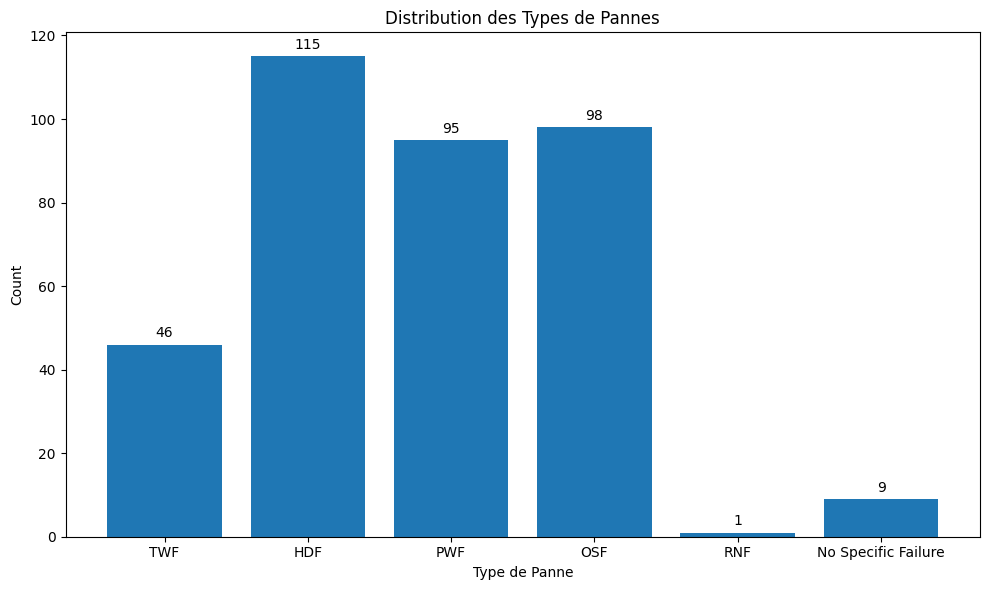

In [92]:
df_failed = df[df['Machine failure'] == 1]

# Count each failure type
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = df_failed[failure_types].sum()

# Count "No Specific Failure" cases: all failure types are 0 even though Machine failure == 1
no_specific_failure_count = ((df_failed[failure_types].sum(axis=1) == 0)).sum()

# Add it to the failure counts
failure_counts['No Specific Failure'] = no_specific_failure_count

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(failure_counts.index, failure_counts.values)

# Add value labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}', ha='center', va='bottom')

plt.title('Distribution des Types de Pannes')
plt.xlabel('Type de Panne')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

Ainsi 9 échecs n'ont pas été identifié parmi les erreurs possibles. De plus, une diférence de 9 échecs aléatoires ont été identifié par rapport au graphique précédent. Ces échecs ne sont réellement grave car ils ne mettent pas en échec les machines.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [93]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

Les entrées utilisées pour le modèle vont être:

*   Type
*   Air temperature
*   Process temperature
*   Rotational speed
*   Torque
*   Tool wear

La sortie va correspondre au type d'echecs parmis les catégorie suivantes:


*   TWF
*   HDF
*   PWF
*   OSF

Nous prenons pas le type RNF en considération dans la classification car seulement 1 machine a été catégorisé par ce type ce qui n'est pas suffisant pour générer une généralité au modèle et il est difficile de faire du machine learning sur de l'aléatoire. De plus, nous ne prenons pas en considération le non speficific failure car le but est de catégoriser le type de failure.











## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [94]:
X = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
Y = df[['TWF', 'HDF', 'PWF', 'OSF']]
no_error_condition = (Y[['TWF', 'HDF', 'PWF', 'OSF']] == 0).all(axis=1)

# Ajouter une colonne "No Error" dans Y, avec la valeur "No Error" pour les machines sans erreur
Y['Error Class'] = np.where(no_error_condition, 'No Error', Y.idxmax(axis=1))
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y['Error Class'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)

# Afficher le nombre d'éléments dans chaque ensemble
print(f"X_train: {len(X_train)}")
print(f"Y_train: {len(Y_train)}")
print(f"X_test: {len(X_test)}")
print(f"Y_test: {len(Y_test)}")


X_train: 8000
Y_train: 8000
X_test: 2000
Y_test: 2000


<ipython-input-94-059b8a8a3cf3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['Error Class'] = np.where(no_error_condition, 'No Error', Y.idxmax(axis=1))


**QUESTION** Code below the model architecture

In [95]:

model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.05),
    Dense(64, activation='relu'),
    Dropout(0.05),
    Dense(32, activation='relu'),
    Dense(5, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_41 (Dense)                     │ (None, 128)                 │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,269 (44.02 KB)

 Trainable params: 11,269 (44.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6640 - loss: 11.0941 - val_accuracy: 0.9705 - val_loss: 0.9828
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9605 - loss: 1.0711 - val_accuracy: 0.9705 - val_loss: 0.5646
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9509 - loss: 0.6935 - val_accuracy: 0.9705 - val_loss: 0.3736
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9546 - loss: 0.5606 - val_accuracy: 0.9705 - val_loss: 0.2452
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9517 - loss: 0.4483 - val_accuracy: 0.9705 - val_loss: 0.2364
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9602 - loss: 0.3328 - val_accuracy: 0.9705 - val_loss: 0.1571
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9592 - loss: 0.3067 - val_accuracy: 0.9705 - val_loss: 0.1397
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9576 - loss: 0.2486 - val_accuracy: 0.9705 - val_los

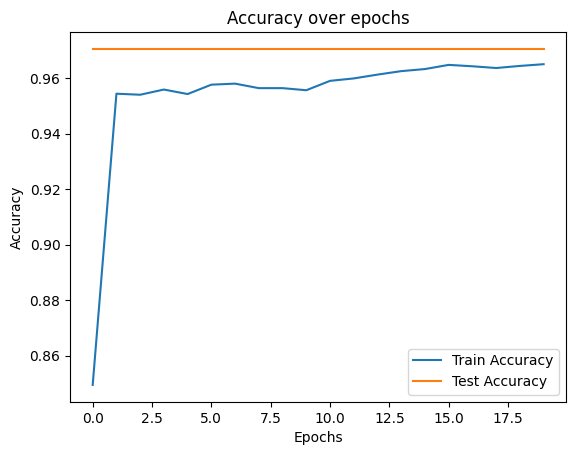

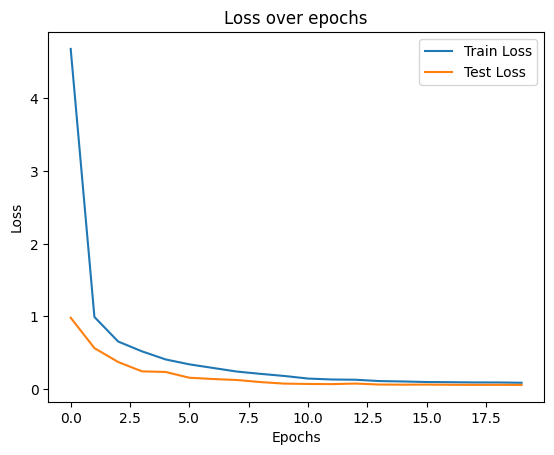

In [96]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()
Y_train = to_categorical(Y_train, num_classes=5)  # Assuming 5 classes
Y_test = to_categorical(Y_test, num_classes=5)
history = model.fit(X_train, Y_train, epochs=20, batch_size=300, validation_data=(X_test, Y_test))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


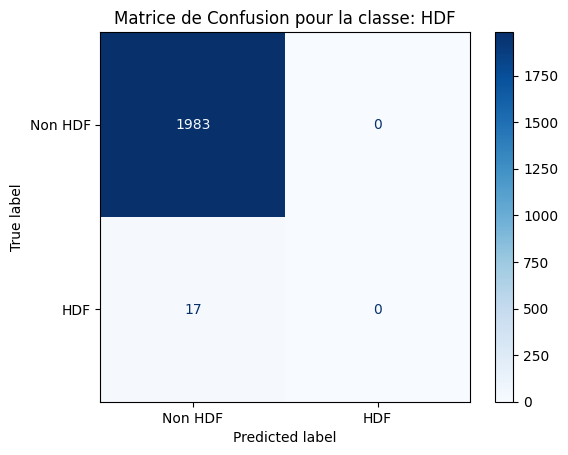

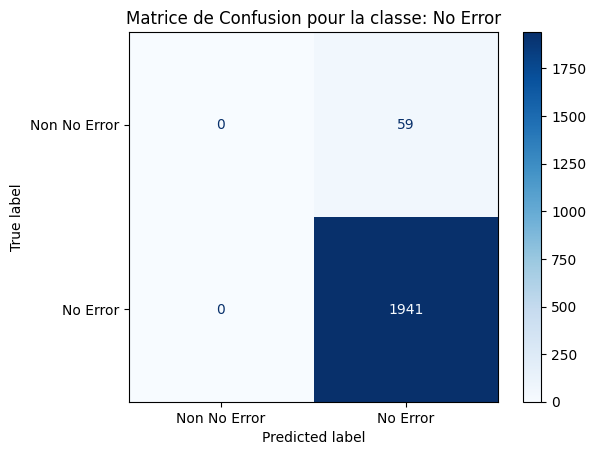

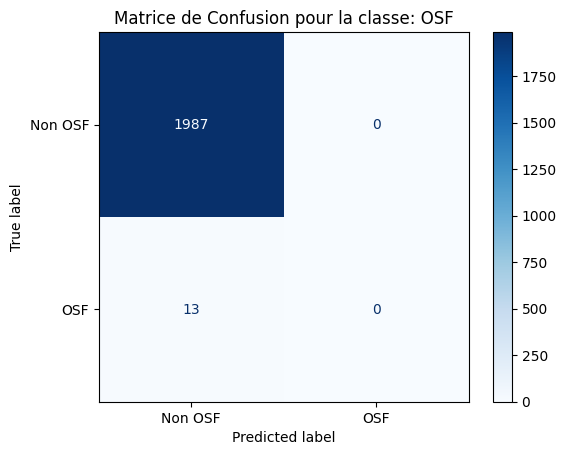

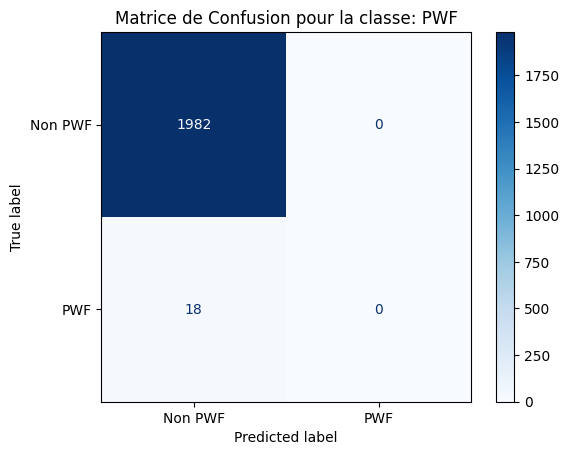

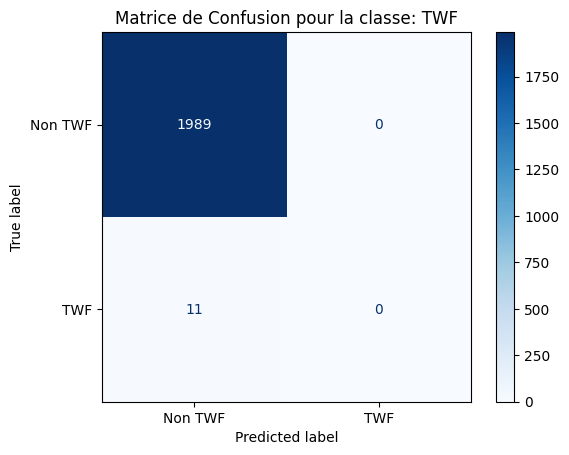

In [97]:
# Prédictions du modèle sur X_test
Y_pred = model.predict(X_test)

# Convertir les probabilités en classes (en prenant l'index de la classe avec la probabilité la plus élevée)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Convertir Y_test de one-hot en classes (retourner aux labels originaux)
Y_test_classes = np.argmax(Y_test, axis=1)

# Créer la matrice de confusion pour chaque classe individuellement
for i, label in enumerate(label_encoder.classes_):
    # Transformer les labels en binaire pour la classe i (1 si la classe est correcte, 0 sinon)
    Y_test_binary = (Y_test_classes == i).astype(int)
    Y_pred_binary = (Y_pred_classes == i).astype(int)

    # Calculer la matrice de confusion pour la classe i
    cm = confusion_matrix(Y_test_binary, Y_pred_binary)

    # Affichage de la matrice de confusion
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non " + label, label])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Matrice de Confusion pour la classe: {label}')
    plt.show()

#Grande matrice de confusion
cm = confusion_matrix(Y_test_classes, Y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.show()

**ANALYSIS QUESTION** What do you observe? What can you conclude?

D'après le modèle, la précision est de 96%. Cette mesure semble une bonne mesure en soit mais la matrice de confusion nous indique le contraire. En effet, l'ensemble des données ont été prédites comme des machines sans erreur. Cette matrice met en relief le fait qu'il y a une mauvaise répartition des données dan le fichier. Les machines sans errreur sont beaucoup trop présentes dans le fichier ce qui implique une mauvaise détection des erreurs pour le modèle

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [148]:
X_train, X_test_1, Y_train, Y_test_1 = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)
#SMOTE
smote = SMOTE(random_state=42)
X_train_res, Y_train_res = smote.fit_resample(X_train,Y_train)
print("Distribution après SMOTE :", Counter(Y_train_res))
target_count = min(Counter(Y_train_res).values())
undersample_strategy = {label: target_count for label in set(Y_train_res)}

# Undersampling
undersample = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
X_train_over, Y_train_over = undersample.fit_resample(X_train_res, Y_train_res)

print(f"X_train_over: {len(X_train_over)}")
print(f"Y_train_over: {len(Y_train_over)}")
print("Distribution après undersampling :", Counter(Y_train_over))

Distribution après SMOTE : Counter({1: 7729, 3: 7729, 0: 7729, 4: 7729, 2: 7729})
X_train_over: 38645
Y_train_over: 38645
Distribution après undersampling : Counter({0: 7729, 1: 7729, 2: 7729, 3: 7729, 4: 7729})


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

Grace à la question précédente, nous avons observé un déséquilibre dans la base de données. En effet, les classes d'erreur sont sous réprésentées dans le fichier excel. SMOTE permet ainsi de suréchantillonner les modèles sous représenter en générant des exemples synthétiques de la classe minoritaire. De plus, nous pouvons utiliser la méthode d'UnderSampling afin de réduire et supprimer les exemples de  la classe majoritaire de la base de données.

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [149]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train_res),
    y=Y_train_res
)

# Convertir en dictionnaire (Keras attend un dict {classe: poids})
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict) #inutile car tout est à 1

model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.05),
    Dense(64, activation='relu'),
    Dropout(0.05),
    Dense(32, activation='relu'),
    Dense(5, activation='sigmoid')
])

Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Explication des poids** Afin de réussir à obtenir une précision correcte pour le modèle, nous pouvons utiliser la méthode des poids pour valoriser des classes. Cependant, le SMOTE permet d'avoir le meme effectif pour toutes les classes. Ainsi, suite à la méthode SMOTE, il inutile de mettre en place la méthode des poids car l'ensemble des poids est de 1. C'est pourquoi je n'ai pas implenté les poids dans la fonction fit du modèle

**QUESTION** Code below the algorithms allowing to train model


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_92 (Dense)                     │ (None, 128)                 │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,269 (44.02 KB)

 Trainable params: 11,269 (44.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2589 - loss: 7.1497 - val_accuracy: 0.3420 - val_loss: 0.4518
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3686 - loss: 0.8561 - val_accuracy: 0.5120 - val_loss: 0.4133
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4144 - loss: 0.5122 - val_accuracy: 0.5045 - val_loss: 0.4055
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4643 - loss: 0.4404 - val_accuracy: 0.6210 - val_loss: 0.3606
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5130 - loss: 0.3983 - val_accuracy: 0.6155 - val_loss: 0.3576
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5556 - loss: 0.3677 - val_accuracy: 0.5385 - val_loss: 0.3552
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5926 - loss: 0.3429 - val_accuracy: 0.5950 - val_loss: 0.3334
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6122 - loss: 0.3237 - val_accuracy: 0

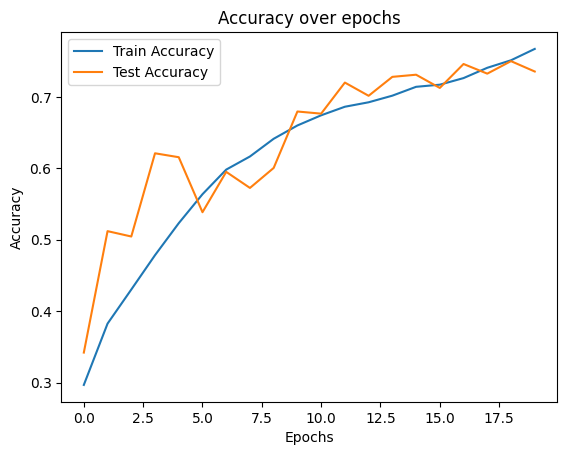

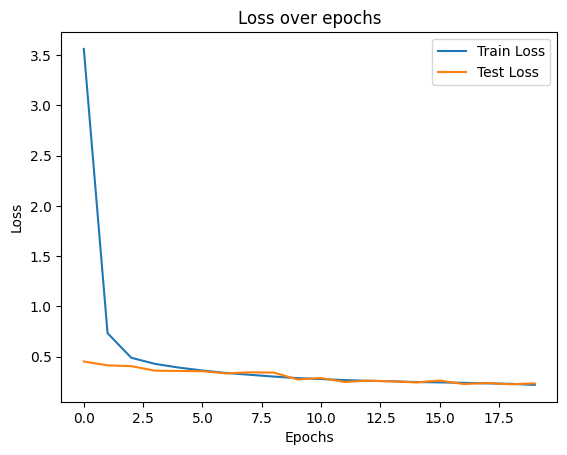

In [150]:
optimizer = Adam(learning_rate=0.0008)
model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()
Y_train_res = to_categorical(Y_train_res, num_classes=5)  # Assuming 5 classes
Y_test_1 = to_categorical(Y_test_1, num_classes=5)
history = model.fit(X_train_res, Y_train_res, epochs=20, batch_size=300, validation_data=(X_test_1, Y_test_1))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**QUESTION** Plot the confusion matrix and the classification report

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


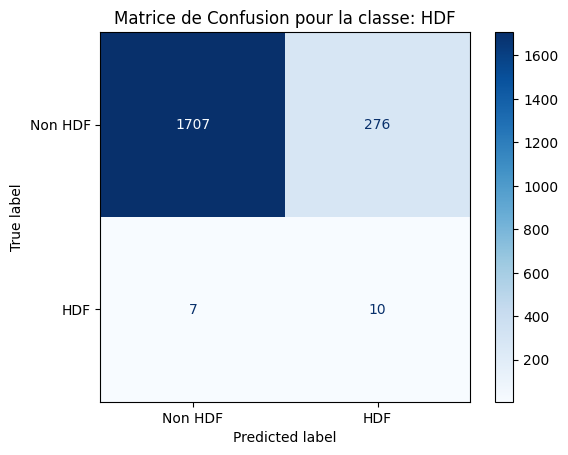

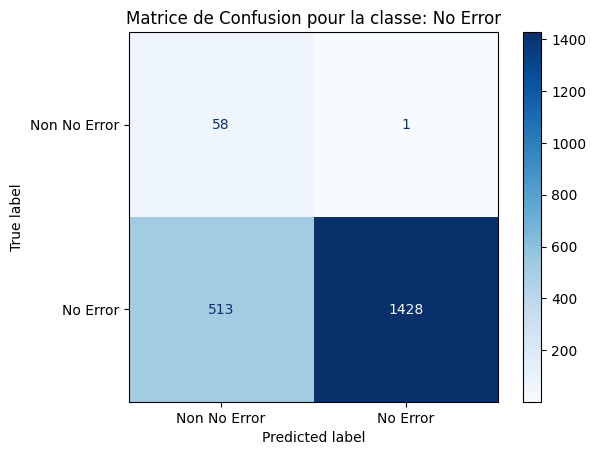

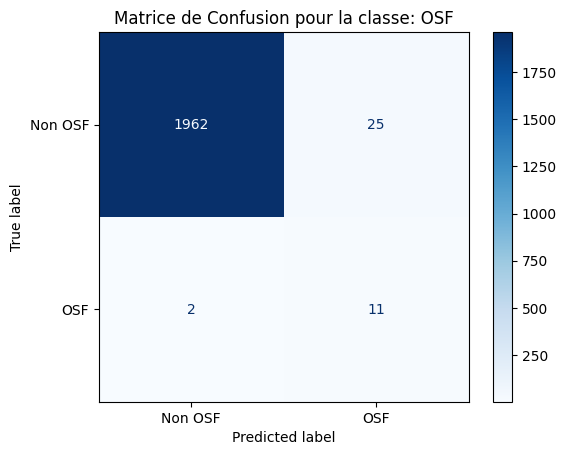

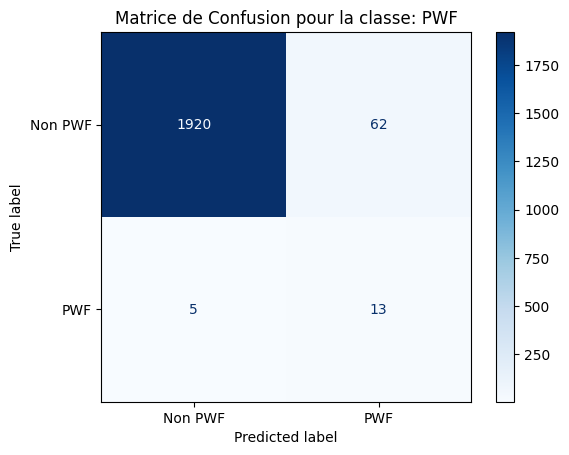

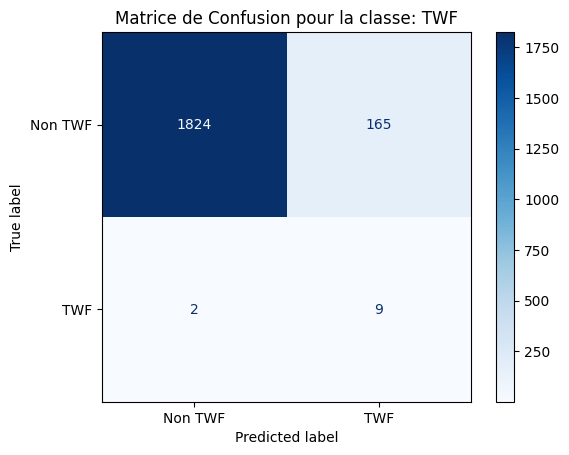

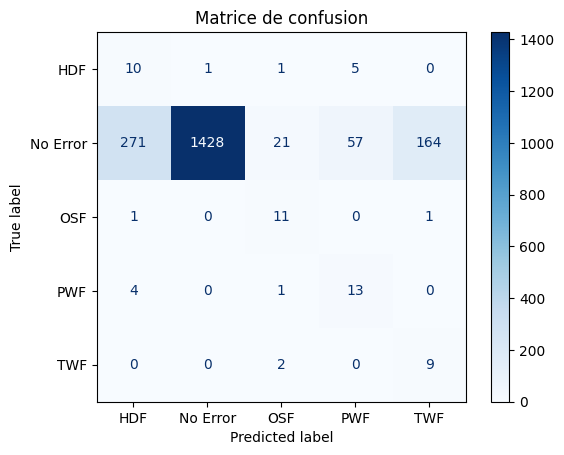

In [153]:
# Prédictions du modèle sur X_test
Y_pred = model.predict(X_test_1)

Y_pred_classes = np.argmax(Y_pred, axis=1)

Y_test_classes = np.argmax(Y_test_1, axis=1)

# Créer la matrice de confusion pour chaque classe individuellement
for i, label in enumerate(label_encoder.classes_):
    Y_test_binary = (Y_test_classes == i).astype(int)
    Y_pred_binary = (Y_pred_classes == i).astype(int)
    cm = confusion_matrix(Y_test_binary, Y_pred_binary)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non " + label, label])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Matrice de Confusion pour la classe: {label}')
    plt.show()

#Grande matrice de confusion
cm = confusion_matrix(Y_test_classes, Y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.show()

**ANALYSIS QUESTION** What do you observe? What can you conclude?

In [152]:
np.save("MNIST_xtest_NN_C2_16_10.npy", X_test_1)
np.save("MNIST_ytest_NN_C2_16_10.npy", Y_test_1)
model.save("MNIST_NN_C2_16_10.h5")

En utilisant la technique de SMOTE, nous avons réussi à réquilibrer la base de données afin d'éviter un overfitting du modèle. On obtient finalement une précision de 70% sans over ni under fitting